# Reinforcement Learning Project

## Environment - Pong (ALE/Pong-v5)

### **Action Space**

There are six discrete actions available:

- `0`: NOOP (do nothing)  
- `1`: FIRE (start the game)  
- `2`: UP (move paddle up)  
- `3`: DOWN (move paddle down)  
- `4`: UPRIGHT (up and right — rarely used)  
- `5`: DOWNRIGHT (down and right — rarely used)

> ⚠️ In most implementations, only actions `0`, `2`, and `3` are typically used.

---

### **Observation Space**

- The observation is an `84 x 84 x 1` grayscale image (after preprocessing).
- Raw observations are `210 x 160 x 3` RGB images.
- Observations represent the game screen including paddles, ball, and scores.

---

### **Rewards**

- `+1` when the agent scores a point.
- `-1` when the opponent scores a point.
- `0` at all other time steps.
- The total episode reward can range from `-21` to `+21`.

---

### **Starting State**

- The game starts with a serve (requires the `FIRE` action).
- The ball's initial direction and speed are randomized for variety.

---

### **Episode Termination**

The episode ends if:

- Episode ends when either player reaches **21 points**.

---

### **Version**

- `ALE/Pong-v5`

[More Information Here](https://gymnasium.farama.org/v0.29.0/environments/atari/pong/)

## Libraries

In [16]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
import cv2
import numpy as np
from utils import run_episodes_get_rewards
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from sb3_contrib import QRDQN
from stable_baselines3 import A2C

## Environment

In [17]:
gym.register_envs(ale_py)
env = gym.make("ALE/Pong-v5", frameskip=5, render_mode="rgb_array")

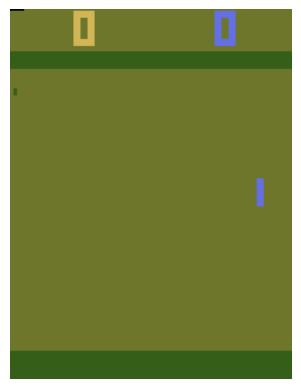

In [5]:
frame = env.reset()
img = env.render()
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
#!pip install "gymnasium[other]"

## 🧱 AtariPreprocessingWrapper: preprocesses frames and stacks them
- Converts RGB to grayscale
- Resizes to 84x84
- Stacks last 4 frames

In [6]:
class AtariPreprocessingWrapper(gym.Wrapper):
    def __init__(self, env, input_shape=(4, 84, 84)):
        super(AtariPreprocessingWrapper, self).__init__(env)
        self.input_shape = input_shape
        self.stacked_frames = np.zeros(self.input_shape, dtype=np.uint8)
        # Update the observation_space to match the preprocessed output
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=self.input_shape, dtype=np.uint8
        )

    def preprocess_frame(self, screen, exclude, output):
        screen = cv2.cvtColor(screen, cv2.COLOR_RGB2GRAY)
        screen = cv2.resize(screen, (output, output), interpolation=cv2.INTER_AREA)
        screen = np.ascontiguousarray(screen, dtype=np.uint8)
        return screen

    def stack_frame(self, stacked_frames, frame, is_new):
        if is_new:
            stacked_frames = np.stack([frame] * 4, axis=0)
        else:
            stacked_frames[:-1] = stacked_frames[1:]
            stacked_frames[-1] = frame
        return stacked_frames

    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        frame = self.preprocess_frame(state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=True)
        return self.stacked_frames, info

    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        frame = self.preprocess_frame(next_state, (8, -12, -12, 4), self.input_shape[1])
        self.stacked_frames = self.stack_frame(self.stacked_frames, frame, is_new=False)
        return self.stacked_frames, reward, terminated, truncated, info

## ✅ Wrap the environment and verify preprocessing output

In [7]:
env_ = AtariPreprocessingWrapper(env)

In [8]:
print(env_.observation_space)

Box(0, 255, (4, 84, 84), uint8)


In [9]:
obs, info = env_.reset()
print("Shape:", obs.shape)        
print("Dtype:", obs.dtype)        
print("Min/Max:", obs.min(), obs.max())  

Shape: (4, 84, 84)
Dtype: uint8
Min/Max: 64 179


## 🖼️ Visualize stacked frames

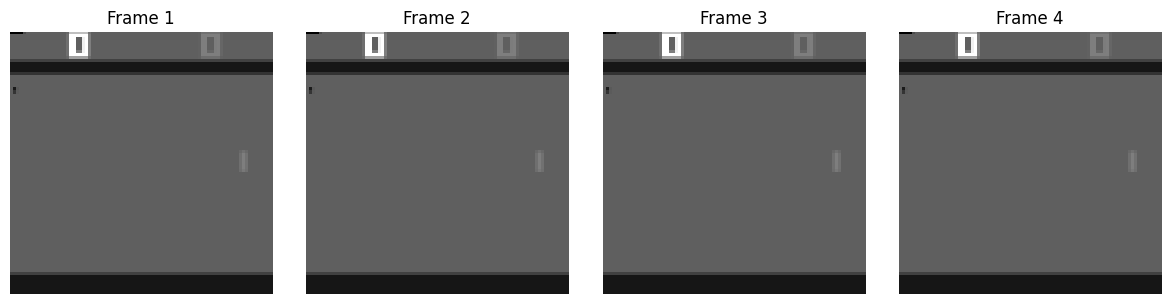

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(obs[i], cmap='gray')
    axs[i].set_title(f'Frame {i+1}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

## 🧠 Train DQN on Pong-v5

In [10]:
model = DQN("CnnPolicy", env_, verbose=1, seed=42, tensorboard_log="./tensorboard_log")

timestamps = 60_000

model.learn(total_timesteps=timestamps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 1.26GB
  warnings.warn(


Logging to ./tensorboard_log/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 709      |
|    ep_rew_mean      | -20      |
|    exploration_rate | 0.551    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 49       |
|    time_elapsed     | 57       |
|    total_timesteps  | 2837     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0757   |
|    n_updates        | 684      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 689      |
|    ep_rew_mean      | -20.4    |
|    exploration_rate | 0.127    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 51       |
|    time_elapsed     | 106      |
|    total_timesteps  | 5511     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss           

## 🏁 Evaluate DQN

In [12]:
episodes = 500

rewards_dqn = run_episodes_get_rewards(model, env_, n_episodes=episodes)

Episode 1: Reward = -21.00
Episode 2: Reward = -20.00
Episode 3: Reward = -21.00
Episode 4: Reward = -21.00
Episode 5: Reward = -21.00
Episode 6: Reward = -21.00
Episode 7: Reward = -21.00
Episode 8: Reward = -21.00
Episode 9: Reward = -21.00
Episode 10: Reward = -21.00
Episode 11: Reward = -21.00
Episode 12: Reward = -21.00
Episode 13: Reward = -21.00
Episode 14: Reward = -21.00
Episode 15: Reward = -20.00
Episode 16: Reward = -21.00
Episode 17: Reward = -21.00
Episode 18: Reward = -20.00
Episode 19: Reward = -21.00
Episode 20: Reward = -21.00
Episode 21: Reward = -21.00
Episode 22: Reward = -21.00
Episode 23: Reward = -21.00
Episode 24: Reward = -20.00
Episode 25: Reward = -21.00
Episode 26: Reward = -21.00
Episode 27: Reward = -21.00
Episode 28: Reward = -21.00
Episode 29: Reward = -21.00
Episode 30: Reward = -21.00
Episode 31: Reward = -21.00
Episode 32: Reward = -21.00
Episode 33: Reward = -21.00
Episode 34: Reward = -21.00
Episode 35: Reward = -21.00
Episode 36: Reward = -21.00
E

## 📈 Plot rewards for DQN

In [ ]:
def plot_rewards(reward_list, title, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.plot(reward_list, label='Reward per Episode')
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.grid()
    plt.legend()
    if save_path:
        plt.savefig(save_path)
    plt.show()

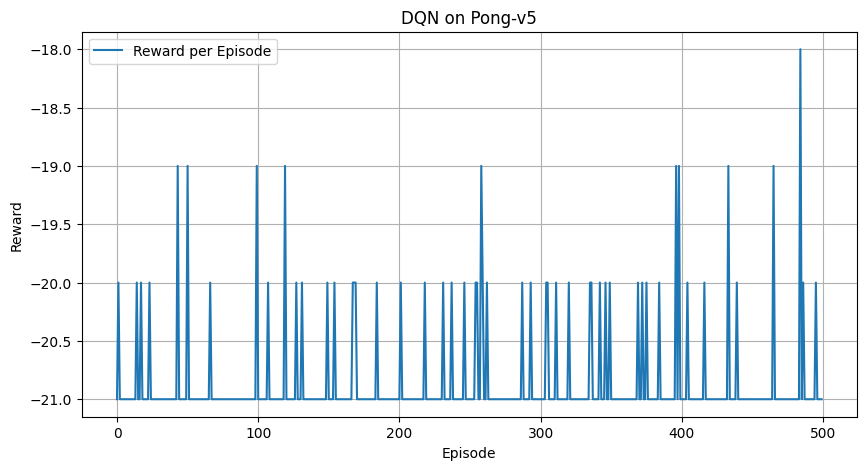

In [14]:
plot_rewards(rewards_dqn, "DQN on Pong-v5")

## 🧠 Train PPO on Pong-v5

In [ ]:
# Initialize model
model_PPO = PPO("CnnPolicy", env_, verbose=1, tensorboard_log="./tensorboard_log")

# Train
model_PPO.learn(total_timesteps=60_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 753      |
|    ep_rew_mean     | -20      |
| time/              |          |
|    fps             | 419      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 730          |
|    ep_rew_mean          | -20.4        |
| time/                   |              |
|    fps                  | 121          |
|    iterations           | 2            |
|    time_elapsed         | 33           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0010542707 |
|    clip_fraction        | 0            |
|    clip_range

## 🏁 Evaluate PPO

In [16]:
episodes = 500

rewards_ppo = run_episodes_get_rewards(model_PPO, env_, n_episodes=episodes)

Episode 1: Reward = -19.00
Episode 2: Reward = -17.00
Episode 3: Reward = -16.00
Episode 4: Reward = -17.00
Episode 5: Reward = -19.00
Episode 6: Reward = -19.00
Episode 7: Reward = -17.00
Episode 8: Reward = -20.00
Episode 9: Reward = -17.00
Episode 10: Reward = -17.00
Episode 11: Reward = -17.00
Episode 12: Reward = -17.00
Episode 13: Reward = -17.00
Episode 14: Reward = -17.00
Episode 15: Reward = -17.00
Episode 16: Reward = -18.00
Episode 17: Reward = -15.00
Episode 18: Reward = -16.00
Episode 19: Reward = -15.00
Episode 20: Reward = -15.00
Episode 21: Reward = -16.00
Episode 22: Reward = -16.00
Episode 23: Reward = -19.00
Episode 24: Reward = -19.00
Episode 25: Reward = -17.00
Episode 26: Reward = -20.00
Episode 27: Reward = -17.00
Episode 28: Reward = -17.00
Episode 29: Reward = -19.00
Episode 30: Reward = -17.00
Episode 31: Reward = -16.00
Episode 32: Reward = -19.00
Episode 33: Reward = -19.00
Episode 34: Reward = -20.00
Episode 35: Reward = -19.00
Episode 36: Reward = -21.00
E

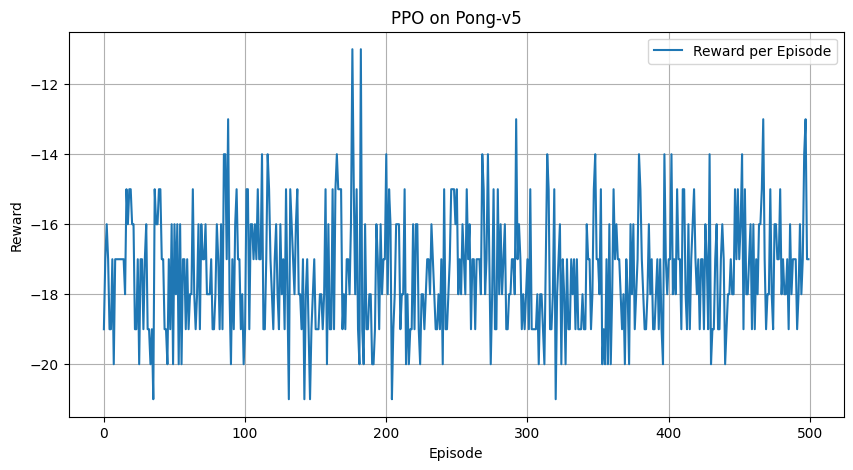

In [17]:
plot_rewards(rewards_ppo, "PPO on Pong-v5")

## 🧠 Train QRDQN on Pong-v5

In [ ]:
model_qrdqn = QRDQN("CnnPolicy", env_, verbose=1, tensorboard_log="./tensorboard_log")
model_qrdqn.learn(total_timesteps=60_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/QRDQN_1


/opt/anaconda3/envs/shhh/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 1.89GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 670      |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 43       |
|    time_elapsed     | 61       |
|    total_timesteps  | 2681     |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 2.62     |
|    n_updates        | 645      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 648      |
|    ep_rew_mean      | -20.8    |
|    exploration_rate | 0.01     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 45       |
|    time_elapsed     | 114      |
|    total_timesteps  | 5187     |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 1.31     |
|    n_updates      

## 🏁 Evaluate QRDQN

In [19]:
episodes = 500
rewards_qrdqn = run_episodes_get_rewards(model_qrdqn, env_, n_episodes=episodes)

Episode 1: Reward = -21.00
Episode 2: Reward = -21.00
Episode 3: Reward = -21.00
Episode 4: Reward = -21.00
Episode 5: Reward = -21.00
Episode 6: Reward = -21.00
Episode 7: Reward = -21.00
Episode 8: Reward = -21.00
Episode 9: Reward = -21.00
Episode 10: Reward = -21.00
Episode 11: Reward = -21.00
Episode 12: Reward = -21.00
Episode 13: Reward = -21.00
Episode 14: Reward = -21.00
Episode 15: Reward = -21.00
Episode 16: Reward = -21.00
Episode 17: Reward = -21.00
Episode 18: Reward = -21.00
Episode 19: Reward = -21.00
Episode 20: Reward = -21.00
Episode 21: Reward = -21.00
Episode 22: Reward = -21.00
Episode 23: Reward = -21.00
Episode 24: Reward = -21.00
Episode 25: Reward = -21.00
Episode 26: Reward = -21.00
Episode 27: Reward = -21.00
Episode 28: Reward = -21.00
Episode 29: Reward = -21.00
Episode 30: Reward = -21.00
Episode 31: Reward = -21.00
Episode 32: Reward = -21.00
Episode 33: Reward = -21.00
Episode 34: Reward = -21.00
Episode 35: Reward = -21.00
Episode 36: Reward = -21.00
E

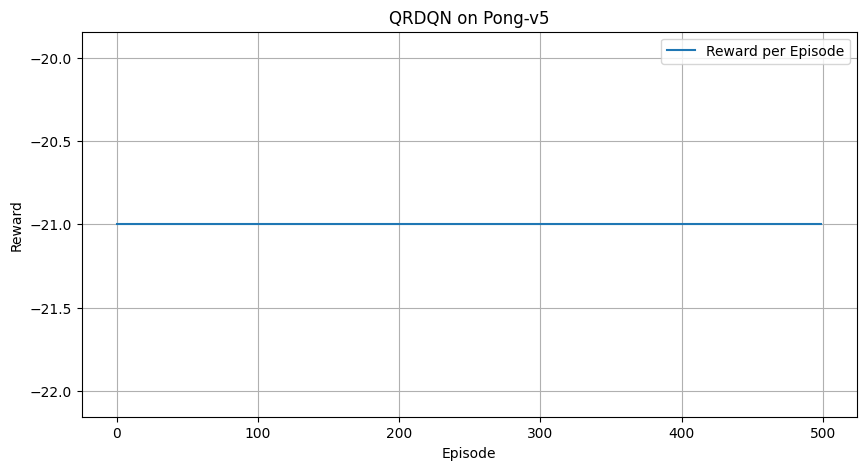

In [20]:
plot_rewards(rewards_qrdqn, "QRDQN on Pong-v5")

## 🧠 Train A2C on Pong-v5

In [ ]:
model_a2c = A2C("CnnPolicy", env_, verbose=1, tensorboard_log="./tensorboard_log")
model_a2c.learn(total_timesteps=60_000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboard_log/A2C_1
-------------------------------------
| time/                 |           |
|    fps                | 204       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.76     |
|    explained_variance | -0.000173 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -0.702    |
|    value_loss         | 0.382     |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 683      |
|    ep_rew_mean        | -21      |
| time/                 |          |
|    fps                | 216      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| trai

## 🏁 Evaluate A2C

In [23]:
episodes = 500
rewards_a2c = run_episodes_get_rewards(model_a2c, env_, n_episodes=episodes)

Episode 1: Reward = -21.00
Episode 2: Reward = -21.00
Episode 3: Reward = -21.00
Episode 4: Reward = -21.00
Episode 5: Reward = -21.00
Episode 6: Reward = -21.00
Episode 7: Reward = -21.00
Episode 8: Reward = -21.00
Episode 9: Reward = -21.00
Episode 10: Reward = -21.00
Episode 11: Reward = -21.00
Episode 12: Reward = -21.00
Episode 13: Reward = -21.00
Episode 14: Reward = -21.00
Episode 15: Reward = -21.00
Episode 16: Reward = -21.00
Episode 17: Reward = -21.00
Episode 18: Reward = -21.00
Episode 19: Reward = -21.00
Episode 20: Reward = -21.00
Episode 21: Reward = -21.00
Episode 22: Reward = -21.00
Episode 23: Reward = -21.00
Episode 24: Reward = -21.00
Episode 25: Reward = -21.00
Episode 26: Reward = -21.00
Episode 27: Reward = -21.00
Episode 28: Reward = -21.00
Episode 29: Reward = -21.00
Episode 30: Reward = -21.00
Episode 31: Reward = -21.00
Episode 32: Reward = -21.00
Episode 33: Reward = -21.00
Episode 34: Reward = -21.00
Episode 35: Reward = -21.00
Episode 36: Reward = -21.00
E

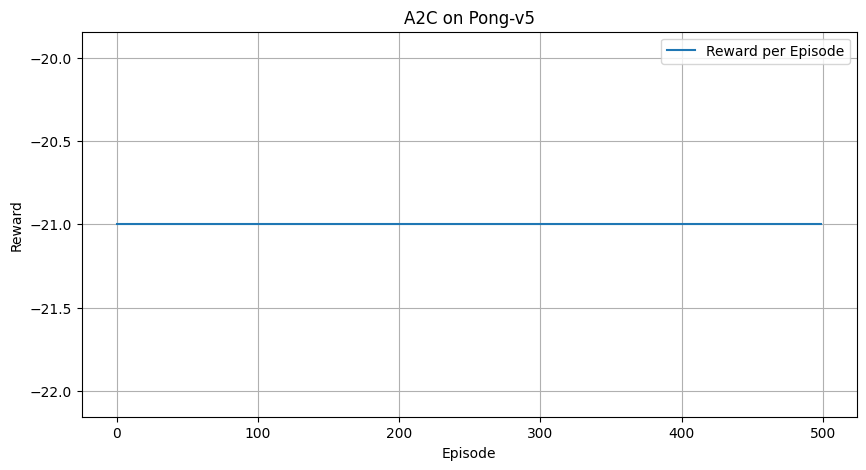

In [24]:
plot_rewards(rewards_a2c, "A2C on Pong-v5")

## 🧠 Train Custom DQN on Pong-v5

In [22]:
import gymnasium as gym
import numpy as np
import cv2
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import ale_py
import matplotlib.pyplot as plt
import cv2
import numpy as np
from utils import run_episodes_get_rewards
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from sb3_contrib import QRDQN
from stable_baselines3 import A2C

In [23]:
# Replay buffer for experience replay
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

# CNN Q-network architecture for Atari input (4x84x84)
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = input_shape
        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),  # out: (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # out: (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # out: (64, 7, 7)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        return self.net(x / 255.0)  # Normalize pixel values to [0,1]

# Epsilon greedy policy
def epsilon_greedy_policy(net, state, epsilon, n_actions, device):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = net(state)
        action = q_values.argmax(dim=1).item()
        return action

In [24]:

# Main training loop
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = gym.make("ALE/Pong-v5", frameskip=5, render_mode="rgb_array")
    env = AtariPreprocessingWrapper(env)

    n_actions = env.action_space.n
    input_shape = env.observation_space.shape

    net = DQN(input_shape, n_actions).to(device)
    target_net = DQN(input_shape, n_actions).to(device)
    target_net.load_state_dict(net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    replay_buffer = ReplayBuffer(100000)

    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_final = 0.01
    epsilon_decay = 30000

    num_frames = 500000  # total training frames
    state, _ = env.reset()
    episode_reward = 0
    episode = 0
    losses = []
    all_rewards = []

    for frame_idx in range(1, num_frames + 1):
        epsilon = epsilon_final + (epsilon_start - epsilon_final) * \
                  np.exp(-1. * frame_idx / epsilon_decay)

        action = epsilon_greedy_policy(net, state, epsilon, n_actions, device)
        next_state, reward, done, truncated, _ = env.step(action)
        done_bool = done or truncated
        replay_buffer.push(state, action, reward, next_state, done_bool)

        state = next_state
        episode_reward += reward

        if done_bool:
            state, _ = env.reset()
            all_rewards.append(episode_reward)
            print(f"Episode {episode} finished. Reward: {episode_reward:.2f}, Frame: {frame_idx}, Epsilon: {epsilon:.3f}")
            episode_reward = 0
            episode += 1

        if len(replay_buffer) > batch_size:
            states_b, actions_b, rewards_b, next_states_b, dones_b = replay_buffer.sample(batch_size)

            states_b = states_b.to(device)
            actions_b = actions_b.to(device)
            rewards_b = rewards_b.to(device)
            next_states_b = next_states_b.to(device)
            dones_b = dones_b.to(device)

            q_values = net(states_b).gather(1, actions_b.unsqueeze(1)).squeeze(1)
            next_q_values = target_net(next_states_b).max(1)[0]
            expected_q_values = rewards_b + gamma * next_q_values * (1 - dones_b)

            loss = nn.functional.mse_loss(q_values, expected_q_values.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        # Update target network every 1000 frames
        if frame_idx % 1000 == 0:
            target_net.load_state_dict(net.state_dict())

    env.close()
    print("Training complete")


In [25]:
if __name__ == "__main__":
    train()


Episode 0 finished. Reward: -20.00, Frame: 711, Epsilon: 0.977
Episode 1 finished. Reward: -19.00, Frame: 1557, Epsilon: 0.950
Episode 2 finished. Reward: -21.00, Frame: 2325, Epsilon: 0.926
Episode 3 finished. Reward: -21.00, Frame: 2937, Epsilon: 0.908
Episode 4 finished. Reward: -21.00, Frame: 3571, Epsilon: 0.889
Episode 5 finished. Reward: -21.00, Frame: 4183, Epsilon: 0.871
Episode 6 finished. Reward: -21.00, Frame: 4913, Epsilon: 0.850
Episode 7 finished. Reward: -20.00, Frame: 5710, Epsilon: 0.828
Episode 8 finished. Reward: -20.00, Frame: 6493, Epsilon: 0.807
Episode 9 finished. Reward: -18.00, Frame: 7402, Epsilon: 0.784
Episode 10 finished. Reward: -21.00, Frame: 8067, Epsilon: 0.767
Episode 11 finished. Reward: -21.00, Frame: 8727, Epsilon: 0.750
Episode 12 finished. Reward: -20.00, Frame: 9446, Epsilon: 0.733
Episode 13 finished. Reward: -21.00, Frame: 10058, Epsilon: 0.718
Episode 14 finished. Reward: -20.00, Frame: 10754, Epsilon: 0.702
Episode 15 finished. Reward: -20.0

KeyboardInterrupt: 

## 📊 Compare All Agents Side-by-Side

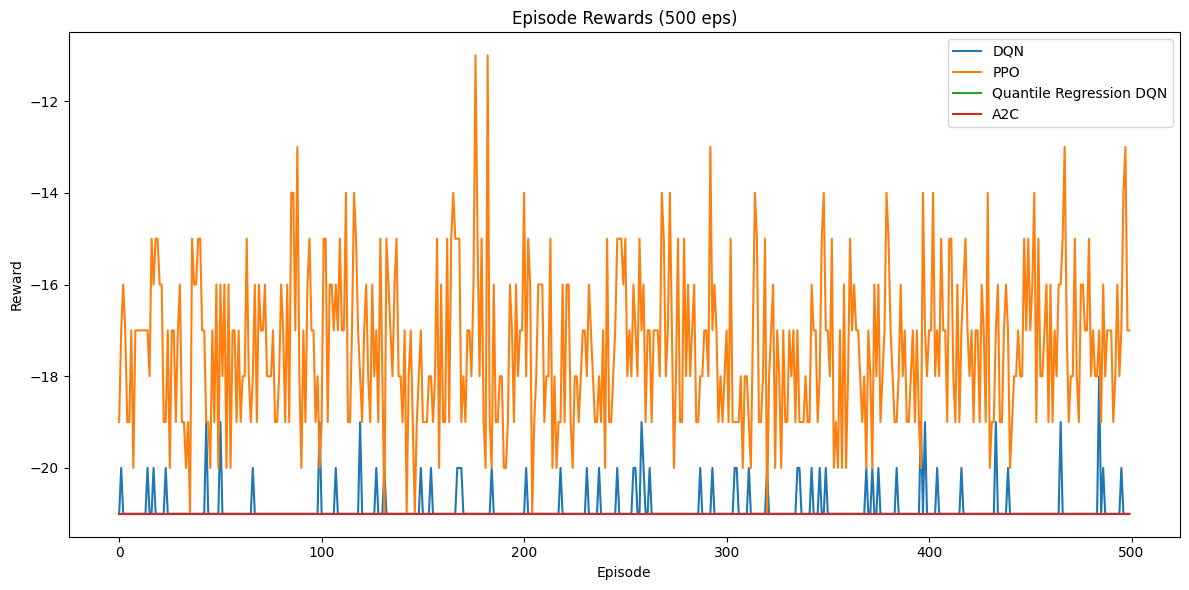

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(rewards_dqn, label="DQN")
plt.plot(rewards_ppo, label="PPO")
plt.plot(rewards_qrdqn, label='Quantile Regression DQN')
plt.plot(rewards_a2c, label="A2C")
plt.title("Episode Rewards (500 eps)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.tight_layout()
plt.show()

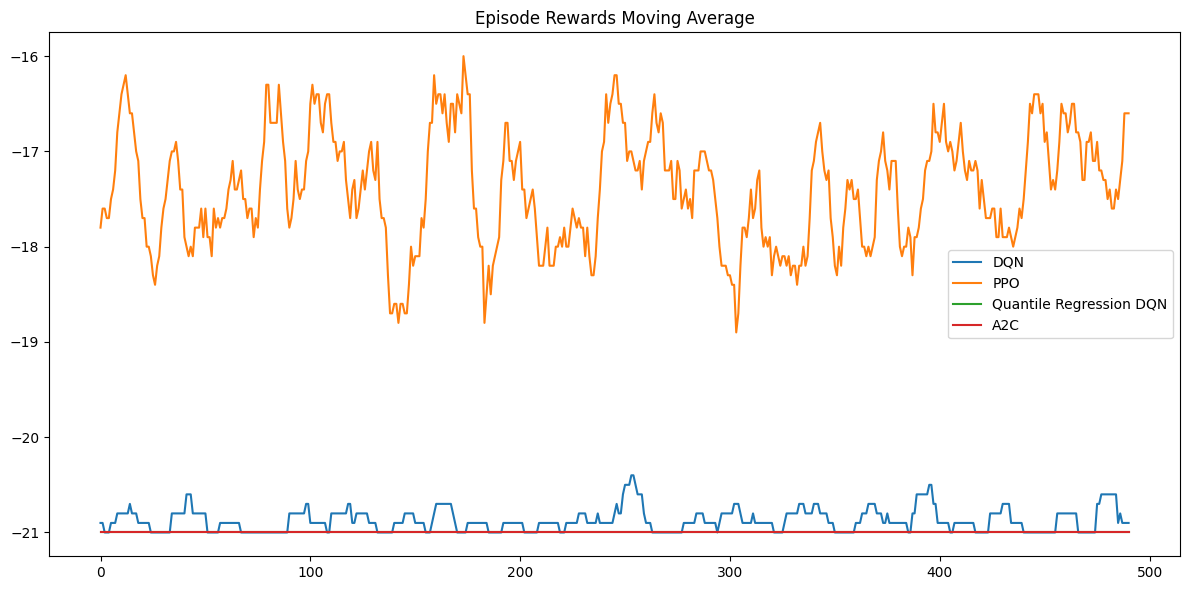

In [ ]:
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot smoothed rewards
plt.figure(figsize=(12, 6))
plt.title("Episode Rewards Moving Average")
plt.plot(moving_average(rewards_dqn), label="DQN")
plt.plot(moving_average(rewards_ppo), label="PPO")
plt.plot(moving_average(rewards_qrdqn), label='Quantile Regression DQN')
plt.plot(moving_average(rewards_a2c), label="A2C")
plt.legend()
plt.tight_layout()
plt.show()